In [1]:
import numpy as np
import netCDF4 as nc
import os
import scipy.io as sio
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import gsw
from salishsea_tools.nc_tools import scDataset
import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
%matplotlib inline


/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
def get_w(dirname, fname, meshmaskname, time_s, time_f):
    
    files = general_functions.get_files(dirname, fname, 'grid_W')        
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(files) as ds:
        vel0 = ds.variables['vovecrtz'][time_s:time_f,:,y,x]
        depth = ds.variables['depthw'][:]
        nav_lat = ds.variables['nav_lat'][y, x]
        nav_lon = ds.variables['nav_lon'][y, x]
    vel = vel0
    return vel, depth, nav_lon, nav_lat

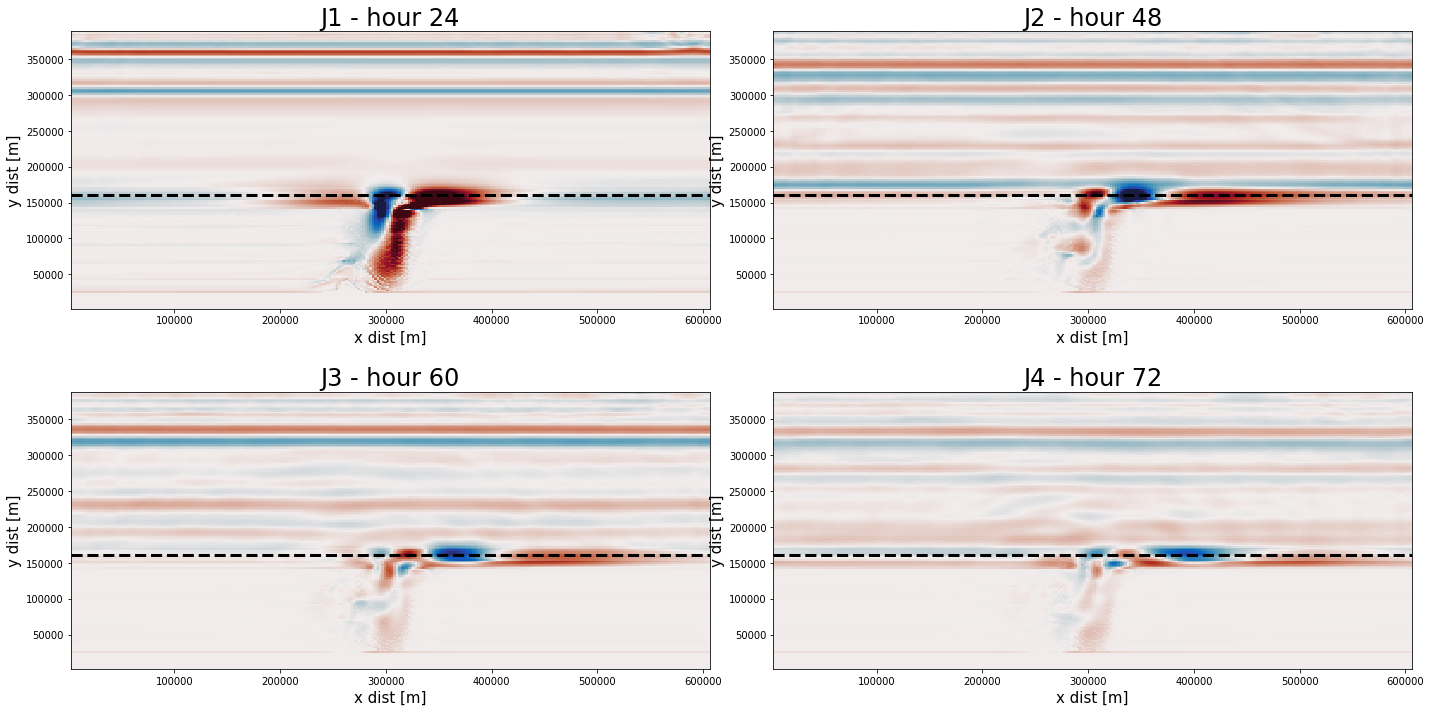

In [10]:
# w velocity
time_s, time_f = 0, 24*4
dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/'
fname = 'MCKNZ_1h_20170101_201701*'
meshmaskname = 'mesh_mask.nc'
w_vel, depth, nav_lon, nav_lat = get_w(dirname, fname, meshmaskname, time_s, time_f)
w_vel_average = np.nanmean(w_vel, axis=1)

# distances
imask = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/mesh_mask.nc')
e1t = np.nanmean(imask['e1t'][0, 1:-1, 1:-1], axis=0)
e2t = np.nanmean(imask['e2t'][0, 1:-1, 1:-1], axis=1)
e1t_sum = np.cumsum(e1t)
e2t_sum = np.cumsum(e2t)

#figure
wave_x = 160
wave_y = 70
times = [24, 48, 60, 72]

fig, axes = plt.subplots(2,2,figsize=(20, 10))
for ax, time, n in zip(axes.flatten(), times, np.arange(len(times))):
    p=ax.pcolormesh(e1t_sum, e2t_sum, w_vel_average[time, :, :], cmap=cmo.cm.balance, vmin=-0.0002, vmax=0.0002)
    ax.axhline(e2t_sum[wave_y], c='k',lw=3,linestyle='--')
    ax.set_xlabel('x dist [m]', fontsize=15)
    ax.set_ylabel('y dist [m]', fontsize=15)
    ax.set_title('J'+str(n+1)+' - hour '+str(time), fontsize=24)
    
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

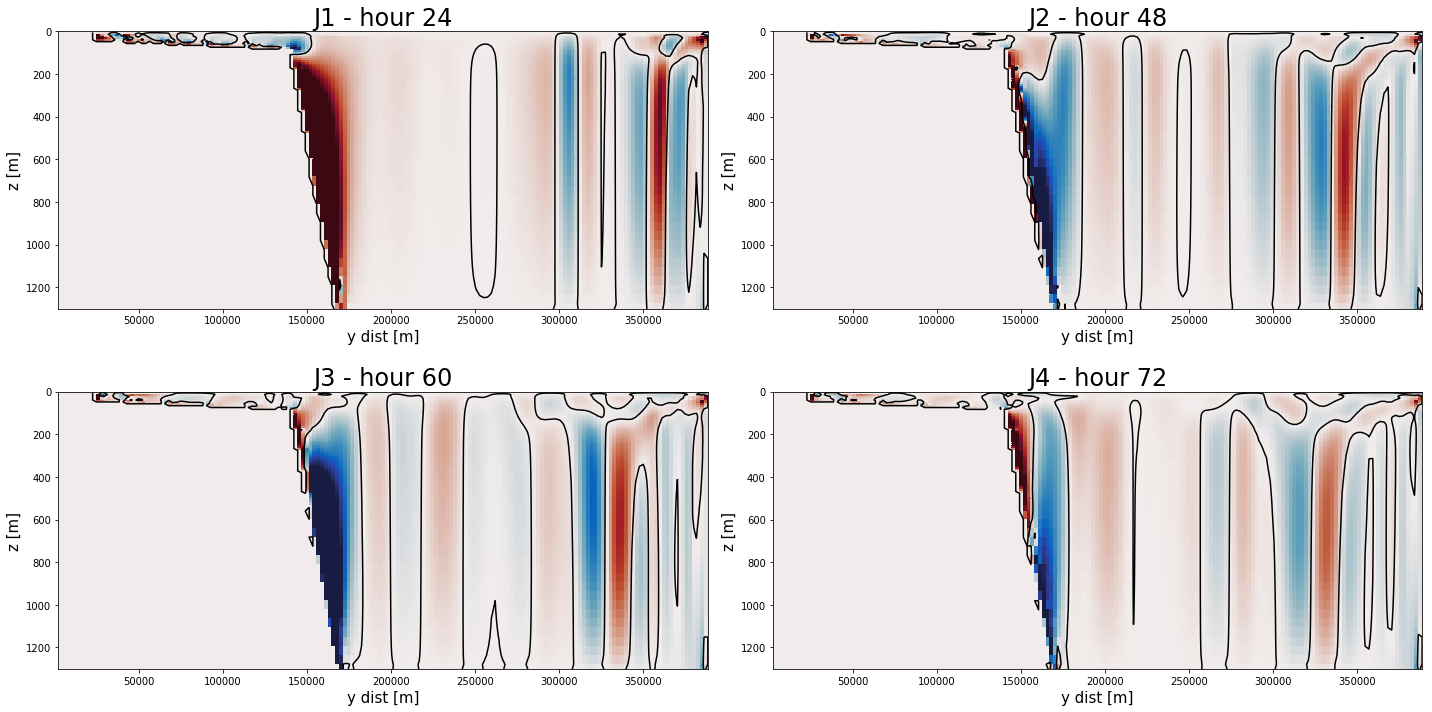

In [27]:
x_ideal = 160
gdept = imask['gdept_1d'][0,:]
fig, axes = plt.subplots(2,2,figsize=(20, 10))
for ax, time, n in zip(axes.flatten(), times, np.arange(len(times))):
    p=ax.pcolormesh(e2t_sum, gdept, w_vel[time, :, :, x_ideal], cmap=cmo.cm.balance, vmin=-0.0002, vmax=0.0002)
    ax.contour(e2t_sum, gdept, w_vel[time, :, :, x_ideal], levels=[0], colors='k')
    ax.set_ylim([1300, 0])
    ax.set_xlabel('y dist [m]', fontsize=15)
    ax.set_ylabel('z [m]', fontsize=15)
    ax.set_title('J'+str(n+1)+' - hour '+str(time), fontsize=24)
    
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

In [4]:
# finding wavelength
wlength_0_m=[i * 1000 for i in [260, 305, 319, 335]]
wlength_f_m=[i * 1000 for i in [341, 415, 455, 510]]

eyeballed from w-velocity maps:

J1
wavelength_m  81000 , wavenumber_radcm  7.757018897752575e-07
J2
wavelength_m  110000 , wavenumber_radcm  5.711986642890533e-07
J3
wavelength_m  136000 , wavenumber_radcm  4.6199891964555783e-07
J4
wavelength_m  175000 , wavenumber_radcm  3.590391604102621e-07


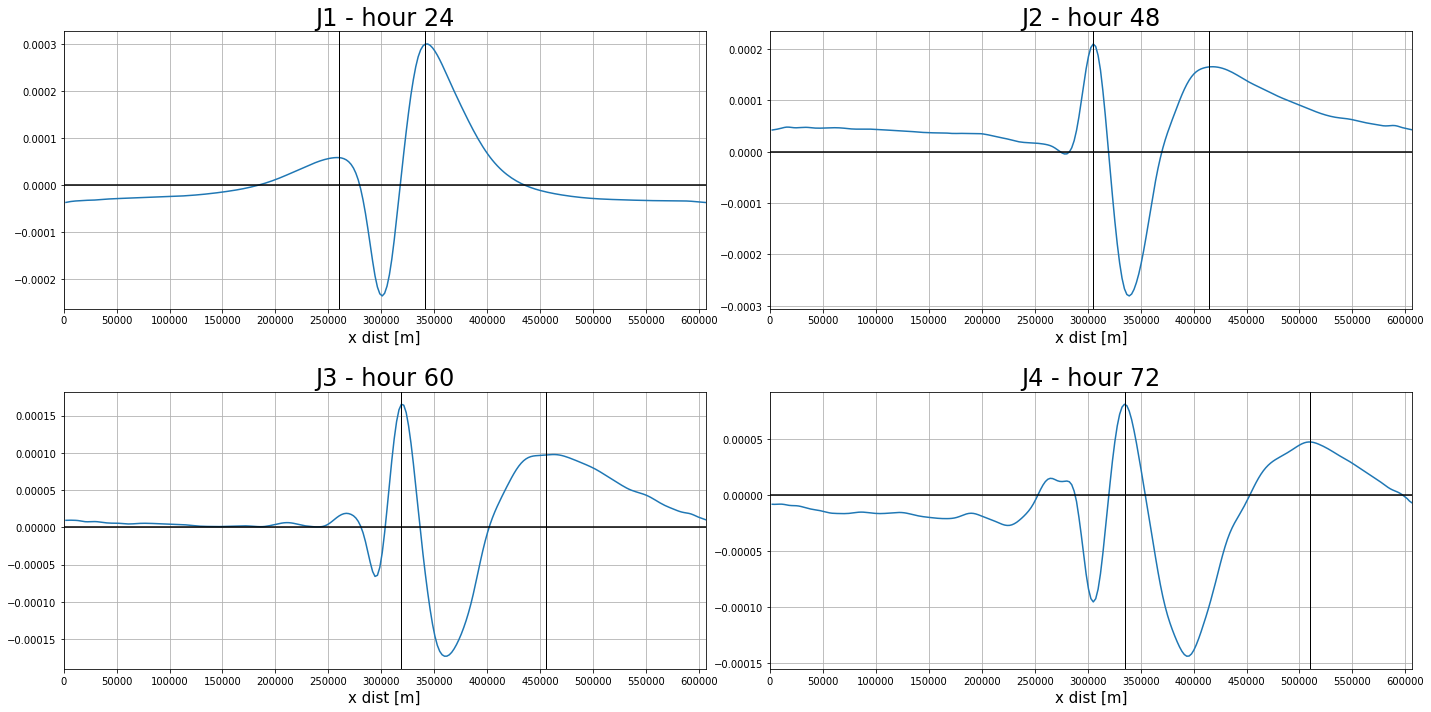

In [50]:
def find_wavek(wlength_0, wlength_f):
    wavelength_m = wlength_f-wlength_0
    wavenumber_radcm = (2*np.pi)/(wavelength_m*100)
    print('wavelength_m ', wavelength_m,', wavenumber_radcm ', wavenumber_radcm)
    return wavenumber_radcm

print('eyeballed from w-velocity maps:\n')
fig, axes = plt.subplots(2,2,figsize=(20, 10))
for ax, time, wlength_0, wlength_f, n in zip(axes.flatten(), times, wlength_0_m, wlength_f_m, np.arange(len(times))):
    
    ax.plot(e1t_sum, w_vel_average[time, wave_y, :])
    ax.set_title('J'+str(n+1)+' - hour '+str(time), fontsize=24)
    ax.axhline(0,c='k')
    ax.grid()
    ax.set_xlim([0, e1t_sum[-1]])
    ax.xaxis.set_ticks(np.arange(0, e1t_sum[-1], 50000))
    ax.set_xlabel('x dist [m]', fontsize=15)
    ax.axvline(wlength_0, c='k',lw=1)
    ax.axvline(wlength_f, c='k',lw=1)
    print('J'+str(n+1))
    wavenumber_radcm = find_wavek(wlength_0, wlength_f)
    
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

In [2]:
def axis_properties(ax, xmin, xmax, ymin, ymax):
    ax.legend(fontsize=20, loc=1)
    ax.axhline(0,lw=2,c='k',zorder=1)
    ax.set_xlabel('wavenumber $\kappa$ (rad/cm)', fontsize=16)
    ax.set_ylabel('frequency $\omega$ (rad/sec)', fontsize=16)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    return

def plot_disp(fname, lab1, lab2):
    fig, (ax, axi) = plt.subplots(1,2,figsize=(20, 5))
    c='#1E90FF'
    output = np.loadtxt('/ocean/imachuca/CTW_Brink/output/'+fname)
    wavenumber = output[:, 0] #rad/cm
    frequency = output[:, 1] #rad/sec
    other_frequency = output[:, 2]
    
    k_last = wavenumber[np.where(frequency<0)[0][0]]
    
    ax.plot(wavenumber, frequency, c=c, alpha=0.9, marker='.', label='k<'+str(k_last))
    axi.plot(wavenumber, other_frequency, c=c, alpha=0.9, marker='.', label='k<'+str(k_last))
    ax.grid(); axi.grid()
    ax.axhline(0.0001368, linestyle='--', c='coral')
    ax.set_title(lab1+lab2, fontsize=20)
    print('highest frequency for ',lab1, '%f' % frequency.max(),'\n')
    
    if lab1=='K':
        ymax = 0.05e-4
    elif lab1=='N':
        ymax = 0.12e-4
    else:
        ymax = 1.4e-4
    axis_properties(ax, 0, 6e-06, -0.5e-5, ymax)
    axis_properties(axi, 0, 6e-06, -5e05, 3e05)
    return fig, ax

highest frequency for  J 0.000127 

eyeballed from w-velocity maps:

J1
wavelength_m  81000 , wavenumber_radcm  7.757018897752575e-07
J2
wavelength_m  110000 , wavenumber_radcm  5.711986642890533e-07
J3
wavelength_m  136000 , wavenumber_radcm  4.6199891964555783e-07
J4
wavelength_m  175000 , wavenumber_radcm  3.590391604102621e-07

**the eyeballed wavenumbers lie along dispersion curve J**


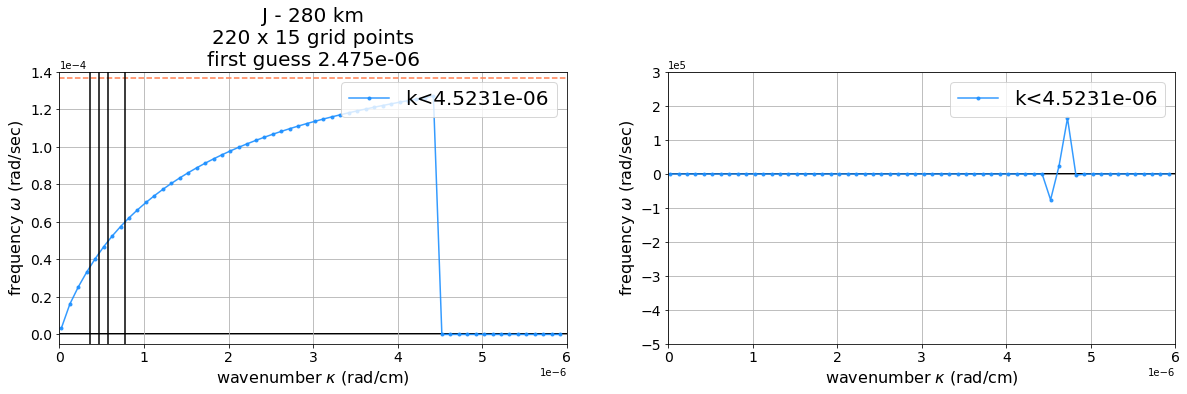

In [52]:
fig, ax = plot_disp('dispc_J.dat', 'J',' - 280 km\n220 x 15 grid points\nfirst guess 2.475e-06')

print('eyeballed from w-velocity maps:\n')
for wlength_0, wlength_f, n in zip(wlength_0_m, wlength_f_m, np.arange(len(times))):
    print('J'+str(n+1))
    wavenumber_radcm = find_wavek(wlength_0, wlength_f)
    ax.axvline(wavenumber_radcm, c='k')
    
print('\n**the eyeballed wavenumbers lie along dispersion curve J**')

highest frequency for  P 0.000127 

no change :(


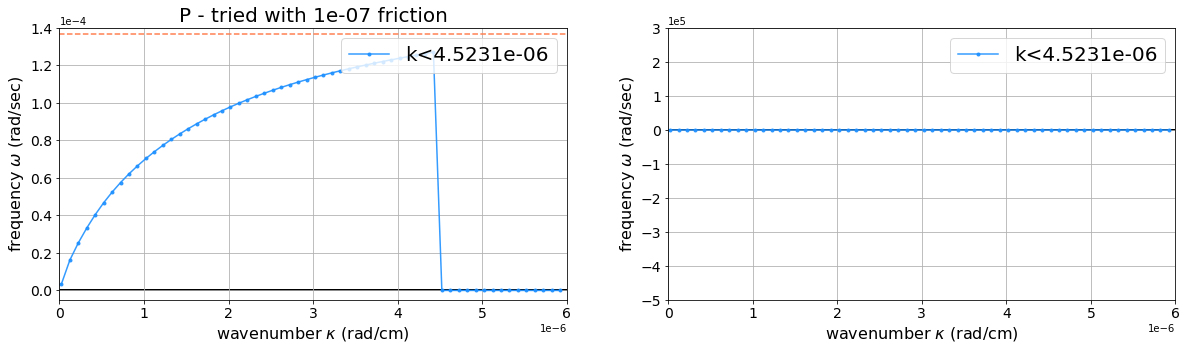

In [6]:
fig, ax = plot_disp('dispc_P.dat', 'P',' - tried with 1e-07 friction')
print('no change :(')

In [53]:
print('given the wavenumbers along the dispersion cuve above, what are their corresponding frequencies?\n')
print('these frequencies are interpolated')

output = np.loadtxt('/ocean/imachuca/CTW_Brink/output/dispc_J.dat')
wavenumber = output[:, 0]
frequency = output[:, 1]

wave_k_eyeballed = [7.757018897752575e-07, 5.711986642890533e-07, 4.6199891964555783e-07, 3.590391604102621e-07]

for wave_k_try, n in zip(wave_k_eyeballed, np.arange(len(times))):
    print('J'+str(n+1))
    f = interpolate.interp1d(wavenumber, frequency)
    wave_f_try = f(wave_k_try)
    print('frequency ', np.round(wave_f_try,8), ', wavenumber ', np.round(wave_k_try,10))

given the wavenumbers along the dispersion cuve above, what are their corresponding frequencies?

these frequencies are interpolated
J1
frequency  6.002e-05 , wavenumber  7.757e-07
J2
frequency  4.951e-05 , wavenumber  5.712e-07
J3
frequency  4.29e-05 , wavenumber  4.62e-07
J4
frequency  3.586e-05 , wavenumber  3.59e-07


highest frequency for  J 0.000127 

the Brink program gives the exact frequency for each wavenumber along curve J


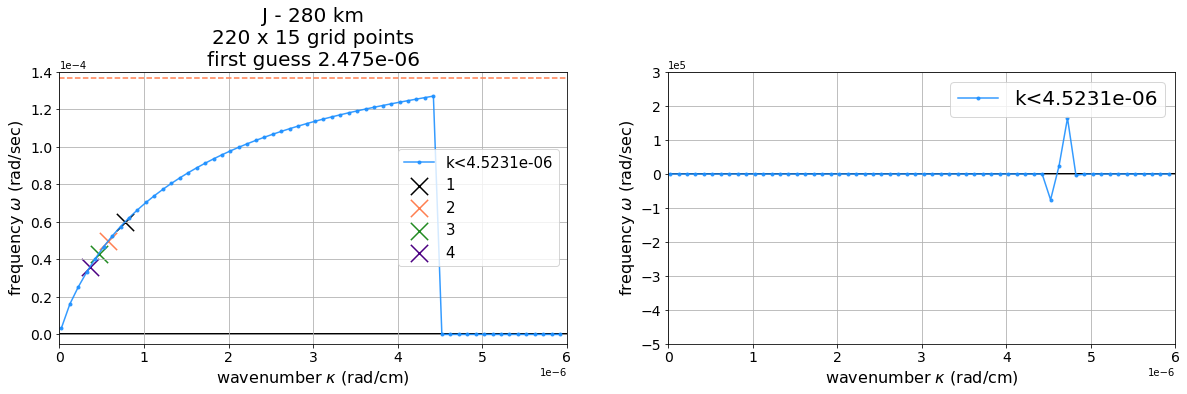

In [54]:
fig, ax = plot_disp('dispc_J.dat', 'J',' - 280 km\n220 x 15 grid points\nfirst guess 2.475e-06')
print('the Brink program gives the exact frequency for each wavenumber along curve J')
ax.scatter(k1, f1, s=300, marker='x', c='k', label='1')
ax.scatter(k2, f2, s=300, marker='x', c='coral', label='2')
ax.scatter(k3, f3, s=300, marker='x', c='forestgreen', label='3')
ax.scatter(k4, f4, s=300, marker='x', c='indigo', label='4')
ax.legend(fontsize=15)

In [55]:
def plot_wave_structure(filename, title):
    file = sio.loadmat('/ocean/imachuca/CTW_Brink/output/'+filename)
    z, xpl, xxx, zzz = file['z'][0,:], file['xpl'][0,:], file['xxx'][0,:], file['zzz'][0,:]
    k, f = file['wavenumber'][0][0], file['frequency'][0][0]
    p, u, v, w, r = file['p_profile'], file['u_profile'], file['v_profile'], file['w_profile'], file['r_profile']
    R = file['ratio_for_wave'][0][0]

    ttls = ['pressure', 'u-velocity', 'v-velocity', 'w-velocity', 'rho']
    fig, axes = plt.subplots(3,2,figsize=(20,14), sharex=True, sharey=True)
    for ax, plot_array, ttl in zip(axes.flatten(), [p, u, v, w, r], ttls):
        if ttl=='pressure' or ttl=='rho':
            cmap=cmo.cm.balance
            norm = upwelling_functions.MidpointNormalize(midpoint=0)
        else:
            cmap=cmo.cm.balance
            norm = upwelling_functions.MidpointNormalize(midpoint=0)
            
        cf = ax.contourf(xpl, z, plot_array, cmap=cmap, norm=norm, zorder=1)
        ax.contour(xpl, z, plot_array, 8, linewidths=0.8, colors='gray', zorder=2)
        c = ax.contour(xpl, z, plot_array, levels=[0], linewidths=2, colors='k', zorder=3)
        ax.clabel(c, fmt='%.1f')
        ax.fill_between(xxx, zzz.min(), zzz, facecolor='#8b7765', zorder=4)
        fig.colorbar(cf, ax=ax)
        ax.set_title(ttl, fontsize=20)
        
    axes[-1, -1].annotate('wavenumber \n'+str(k), (100, -300), fontsize=20)
    axes[-1, -1].annotate('frequency \n'+str(f), (100, -600), fontsize=20)
    axes[-1, -1].annotate('ratio \n'+str(R), (100, -900), fontsize=20)
    axes[-1, -1].axis('off')
        
    fig.tight_layout()
    plt.subplots_adjust(top=0.93, wspace=0.01, hspace=0.1)
    fig.suptitle('Mode - '+title, fontsize=24)
    return fig, k, f

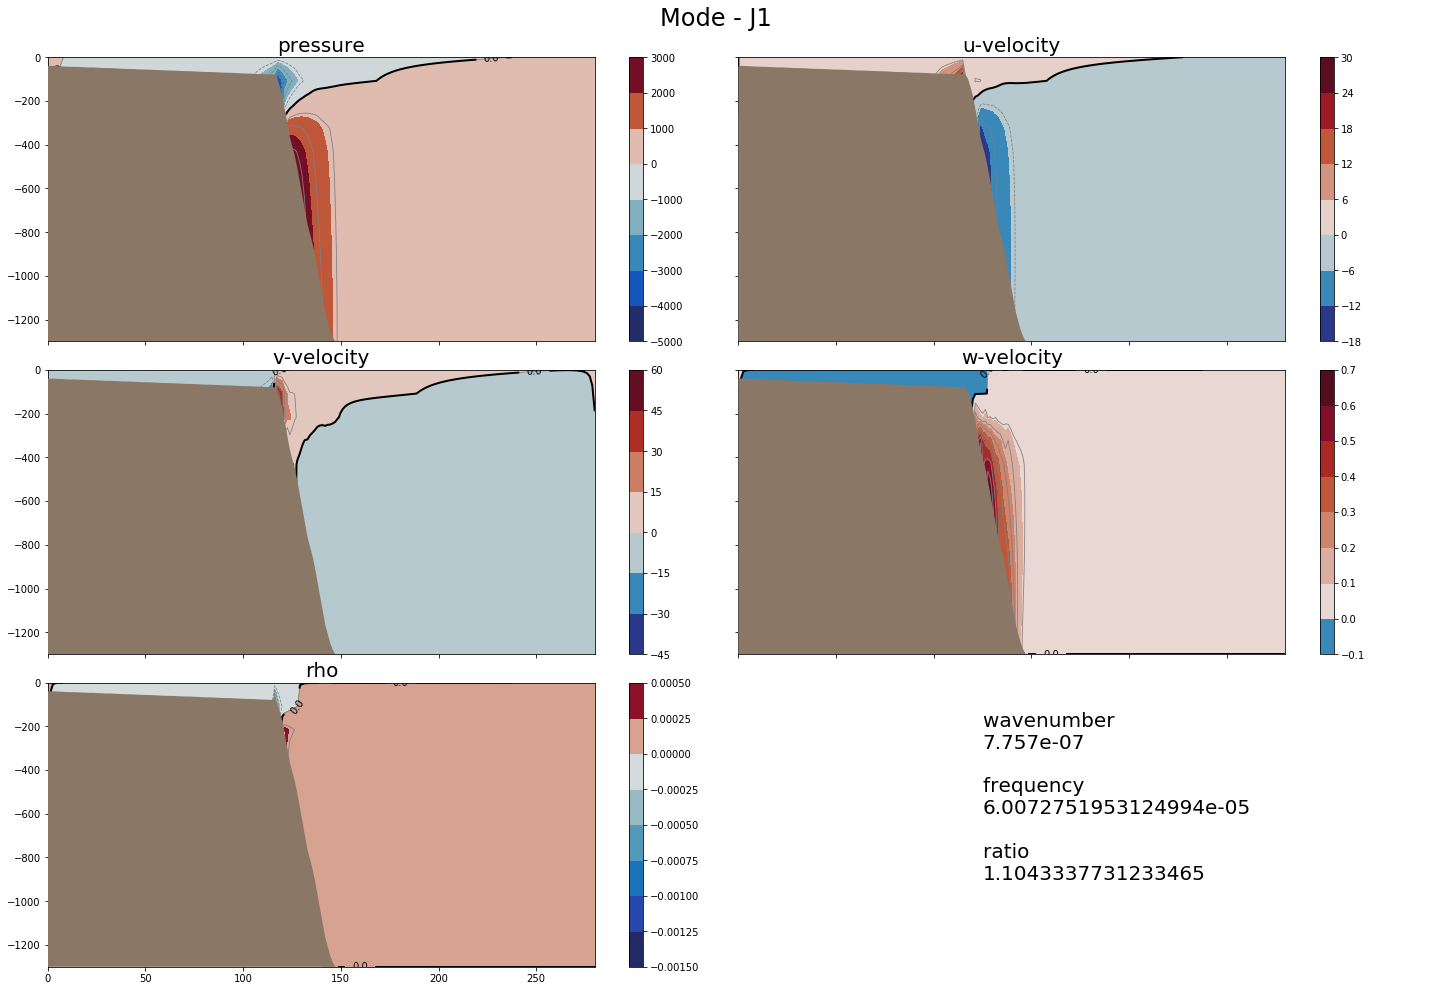

In [56]:
fig, k1, f1 = plot_wave_structure('figures_J1.mat', 'J1')

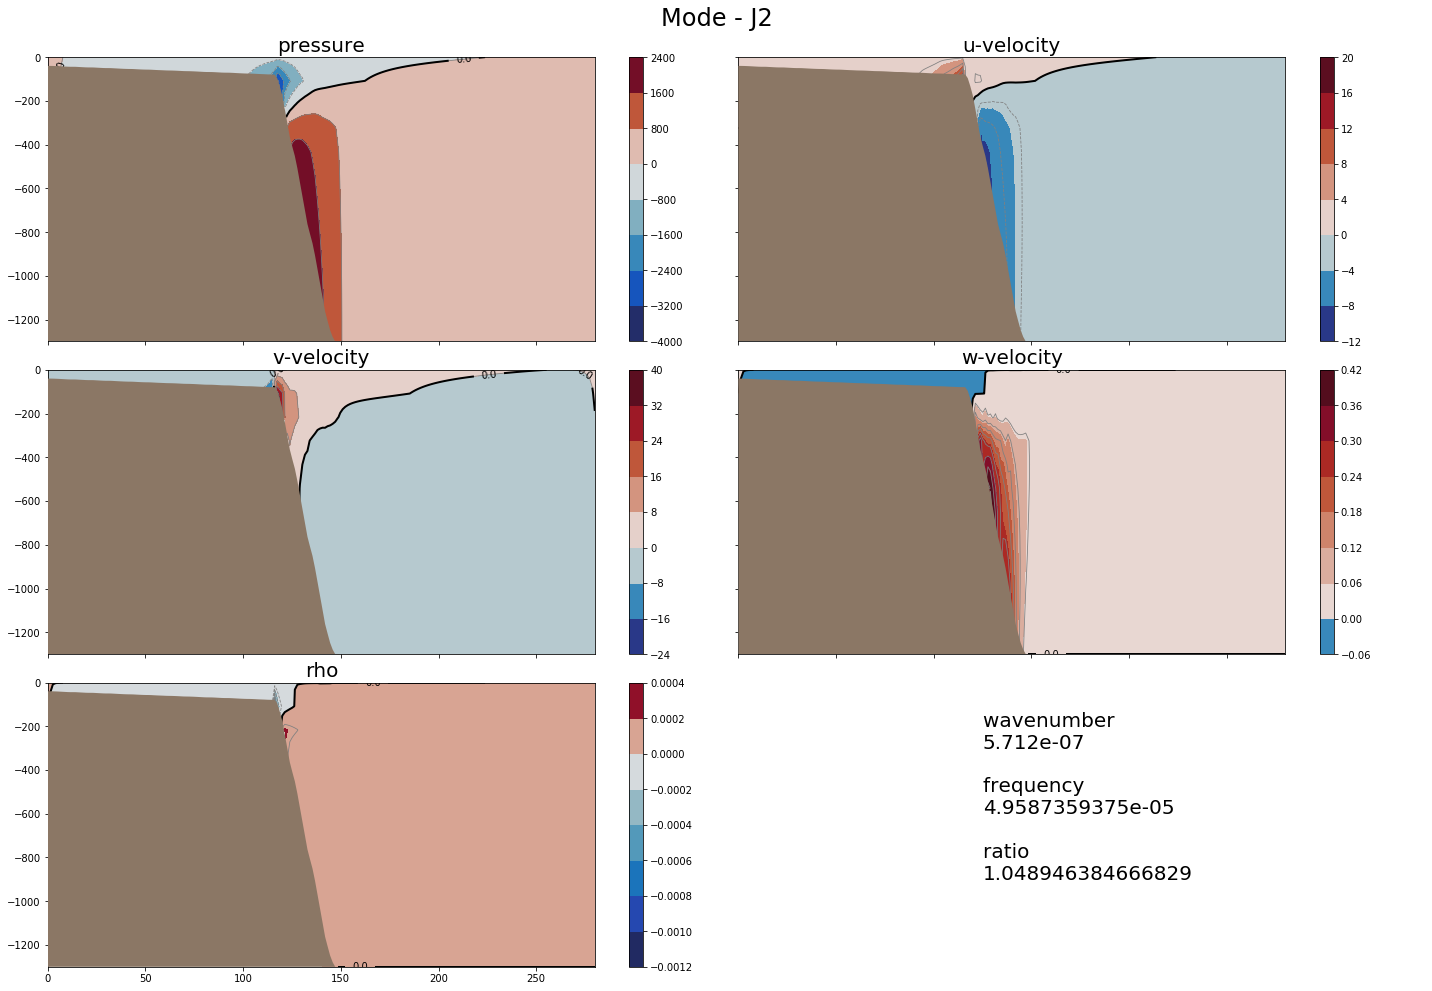

In [57]:
fig, k2, f2 = plot_wave_structure('figures_J2.mat', 'J2')

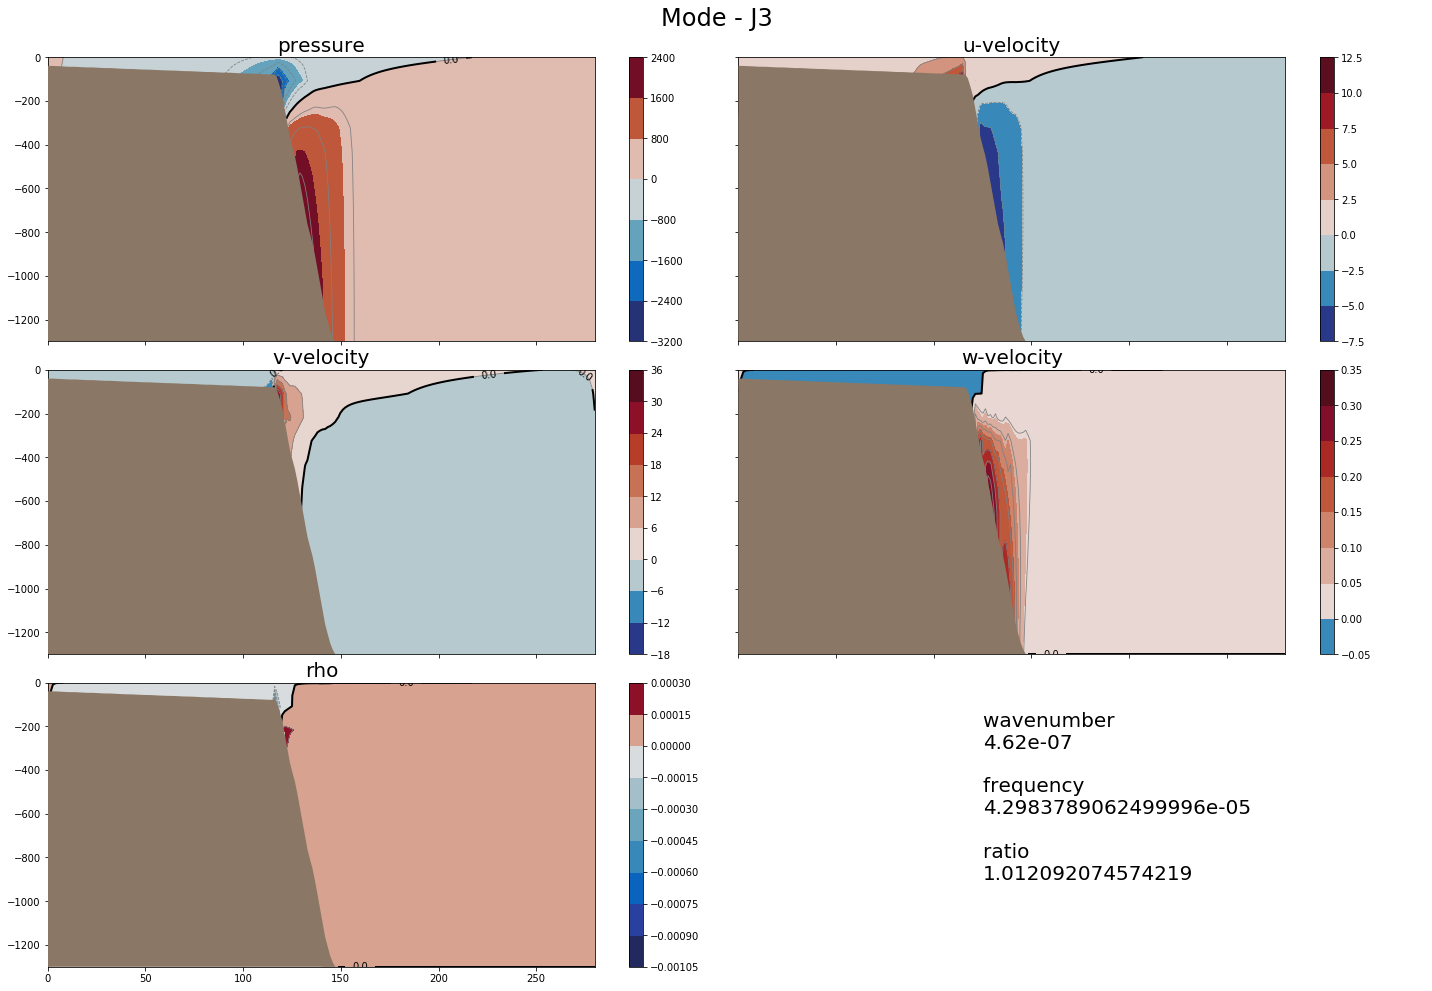

In [58]:
fig, k3, f3 = plot_wave_structure('figures_J3.mat', 'J3')

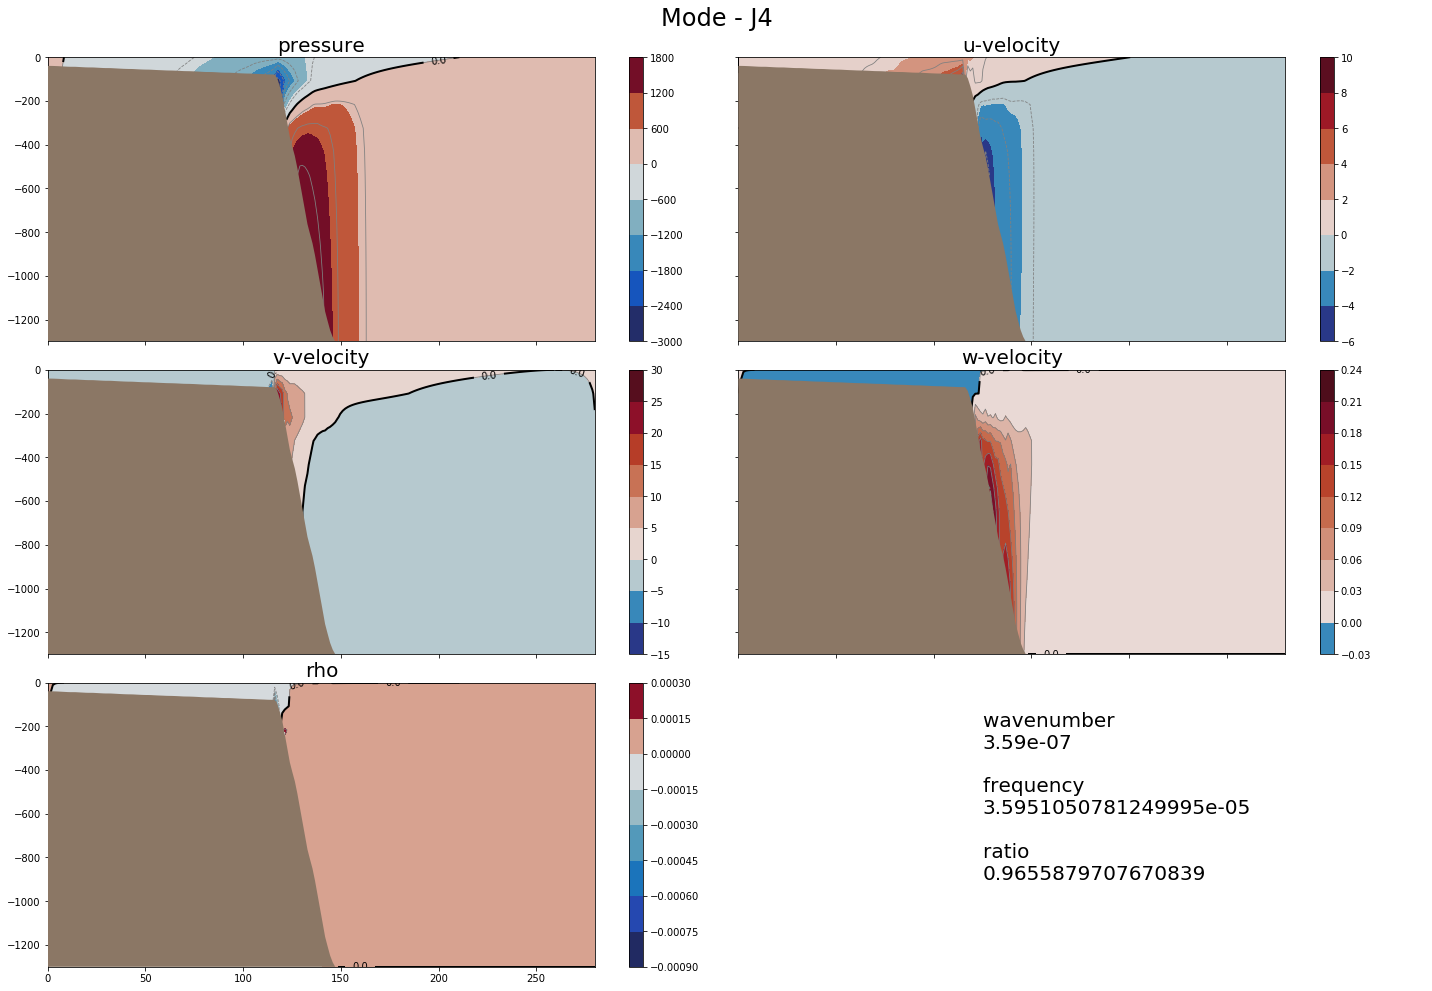

In [59]:
fig, k4, f4 = plot_wave_structure('figures_J4.mat', 'J4')

In [60]:
def plot_line(filename, ind):
    file = sio.loadmat('/ocean/imachuca/CTW_Brink/output/'+filename)
    z, xpl, xxx, zzz = file['z'][0,:], file['xpl'][0,:], file['xxx'][0,:], file['zzz'][0,:]
    p, u, v, w, r = file['p_profile'], file['u_profile'], file['v_profile'], file['w_profile'], file['r_profile']

    ttls = ['pressure', 'u-velocity', 'v-velocity', 'w-velocity', 'rho']
    fig, axes = plt.subplots(3,2,figsize=(20,14))
    for ax, plot_array, ttl in zip(axes.flatten(), [p, u, v, w, r], ttls):
        ax.plot(xpl, plot_array[ind])
        ax.axhline(0, c='k')
        ax.set_title(ttl, fontsize=20)
    axes[-1, -1].axis('off')
    fig.suptitle(filename+' at depth '+str(np.round(z[ind],2)), fontsize=24)
    return fig

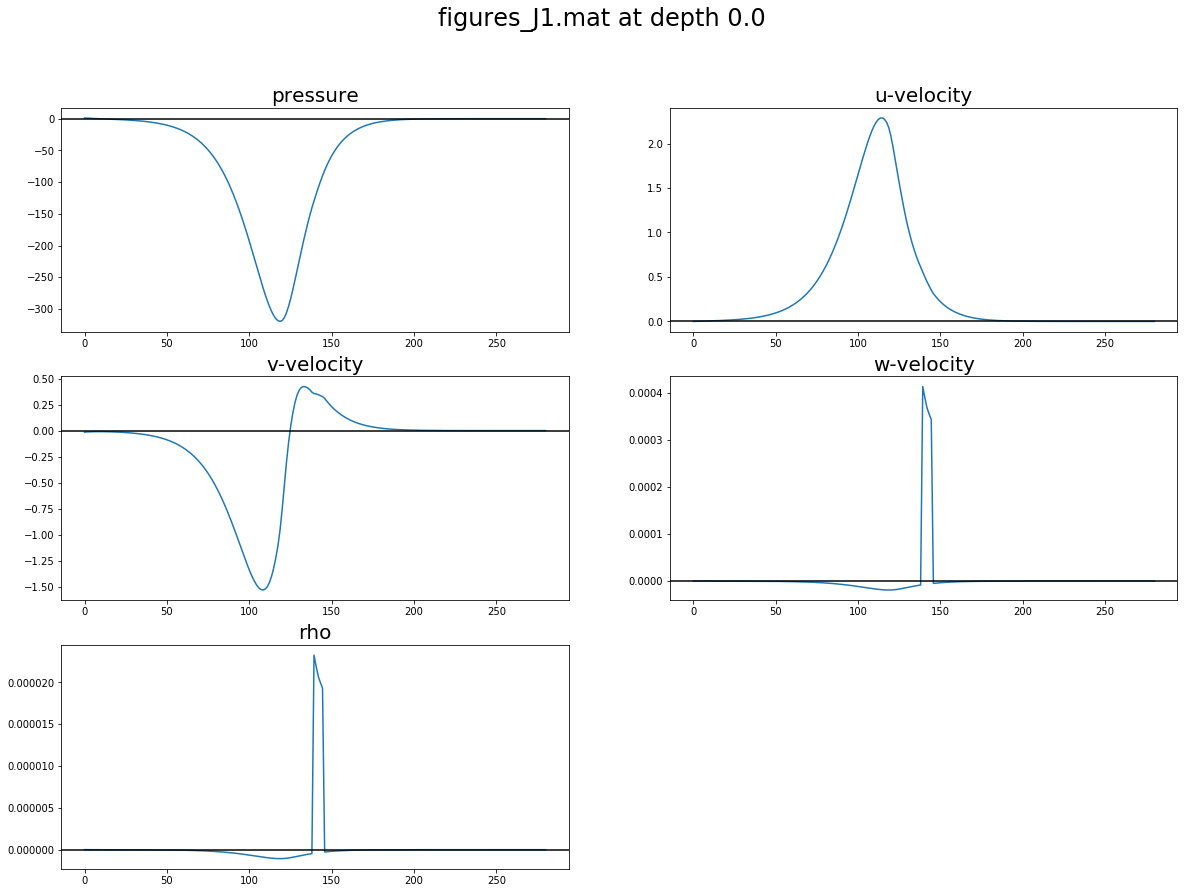

In [61]:
filename, ind = 'figures_J1.mat', 12
fig=plot_line(filename, ind)

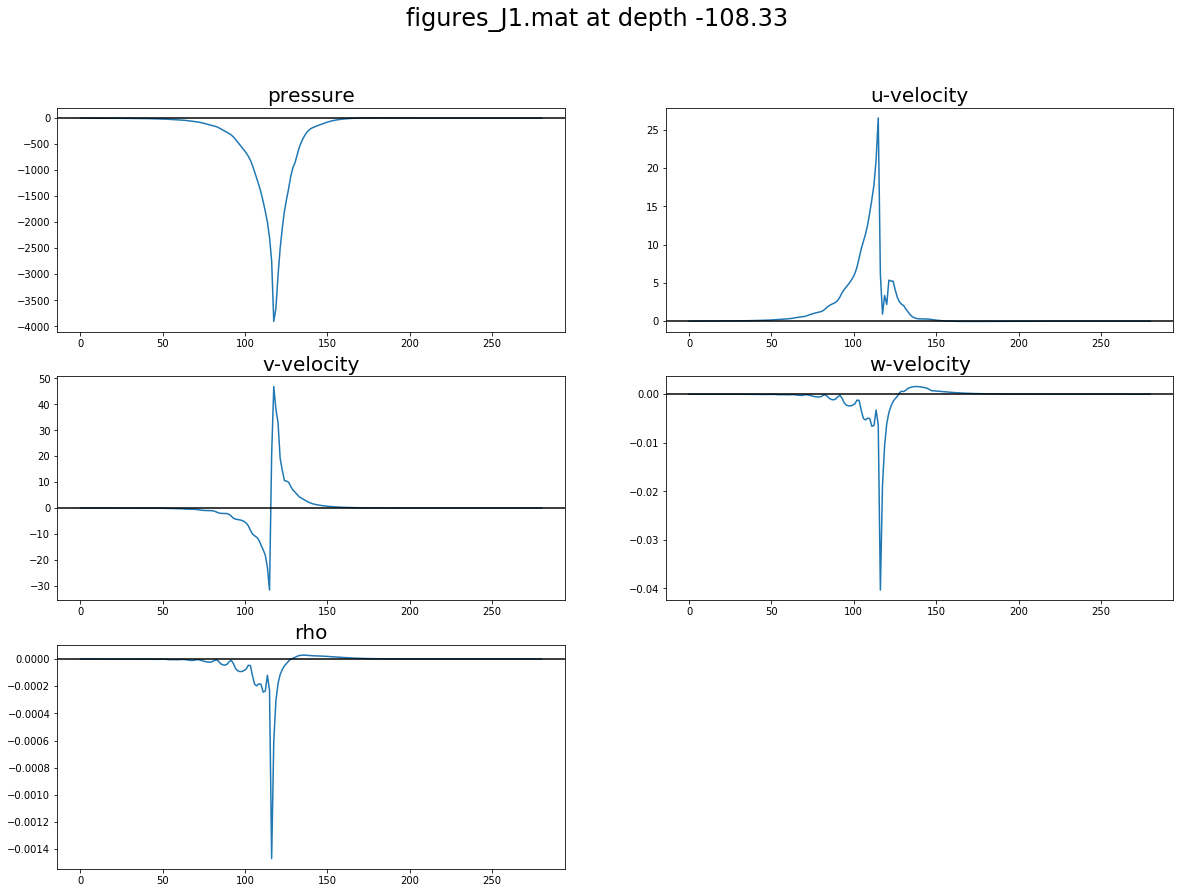

In [62]:
filename, ind = 'figures_J1.mat', 11
fig=plot_line(filename, ind)